Первым делом загружаем данные из соответствующих папок на гугл диске:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = '/content/drive/MyDrive/Данные'
mask_path = '/content/drive/MyDrive/Данные/masks'
#our_data_path = '/content/drive/MyDrive/Colab Notebooks/Распознавание языка/РПР/Рак языка/№1'

In [ ]:
images = []
masks = []
#our_data = []
from skimage.io import imread
import os

#folders = os.listdir(image_path)
#print(sorted(folders))
#unnecessary_values = ['№30', '№31', '№32', '№33', '№34', '№35']
#for value in unnecessary_values:
    # Проходим по списку и удаляем.
 #   folders.remove(value)
#print(sorted(folders))
for group in ['train', 'val']:
  for class_ in ['normal']:
    for folder in sorted(os.listdir(os.path.join(image_path, group, class_))):
      cnt_images=0
      cnt_masks=0
      for filename in sorted(os.listdir(os.path.join(image_path,  group, class_, folder))):
          images.append(imread(os.path.join(image_path, group, class_, folder, filename))) #считываем картинки и кладем их в список
          cnt_images+=1

#for folder in folders:
      for filename in sorted(os.listdir(os.path.join(mask_path, group, class_, folder))):
          masks.append(imread(os.path.join(mask_path, group, class_, folder, filename))) #считываем картинки и кладем их в список
          cnt_masks+=1
    print(folder, cnt_images, cnt_masks)

№9 6 6
№8 6 6


In [ ]:
len(images)

131

Изображения имеют размер $576\times768 $ пикселей. Для корректной работы архитектуры нам нужно $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]
#Y = [resize(y, size, mode='constant', anti_aliasing=True) for y in masks]
#Z = [resize(z, size, mode='constant', anti_aliasing=False) for z in our_data]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
#Z = np.array(Z, np.float32)
print(f'Loaded {len(X)} images')

Loaded 131 images


Чтобы убедиться, что все корректно, нарисуем несколько изображений и их масок

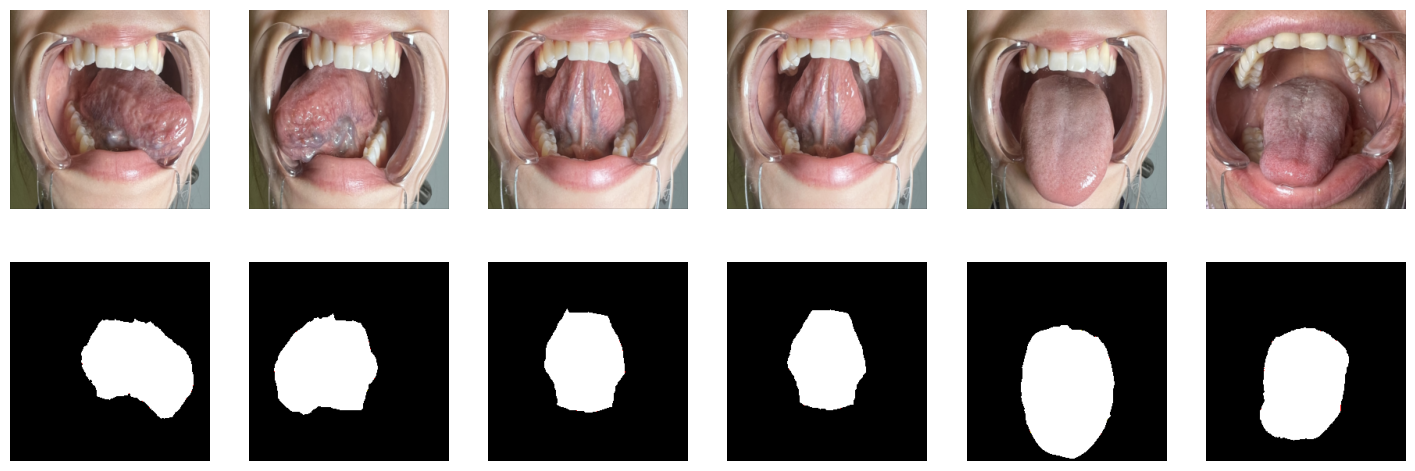

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

### Делаем из трехслойной маски двухслойную (т.е. из (256, 256, 3) делаем (256, 256), кодируя каждый пиксель либо числом 0 (черные), либо числом 255 (белые))

In [ ]:
import numpy as np
def mask_del_layer(mask):
    mask[(0<mask) & (mask<255)]=1
    return mask[:, :, 0]

In [ ]:
masks_two_layers = []
for mask in Y:
    mask_res=mask_del_layer(mask)
    masks_two_layers.append(mask_res)

In [ ]:
masks_two_layers = np.array(masks_two_layers, np.float32)

In [ ]:
np.shape(masks_two_layers)

(131, 256, 256)

### Отображаем новые двухслойные маски (они почему-то фиолетово-желтые, но это нормально)

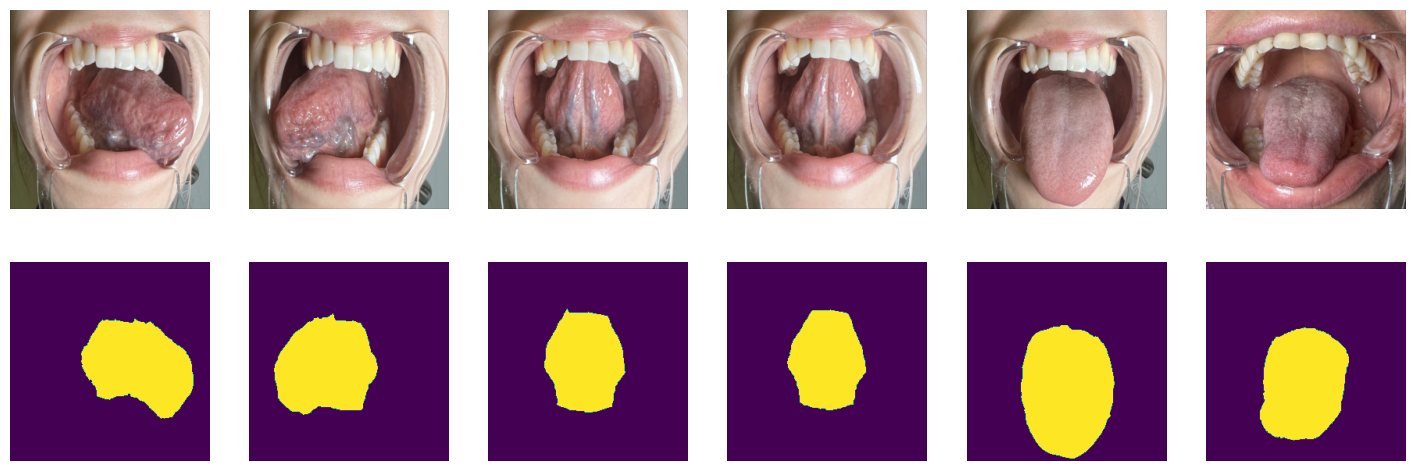

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(masks_two_layers[i])
plt.show();

Вроде всё ок!

Разделим наши 109 картинок на 80/10/19
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 115])

In [ ]:
print(len(tr), len(val), len(ts))

100 15 16


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), masks_two_layers[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), masks_two_layers[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), masks_two_layers[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

#data_tso = DataLoader(list(np.rollaxis(Z[tso], 3, 1)),
 #                    batch_size=3, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Почему бы не попробовать написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них, подобрать гиперпараметры.

-----------------------------------------------------------------------------------------

# SegNet

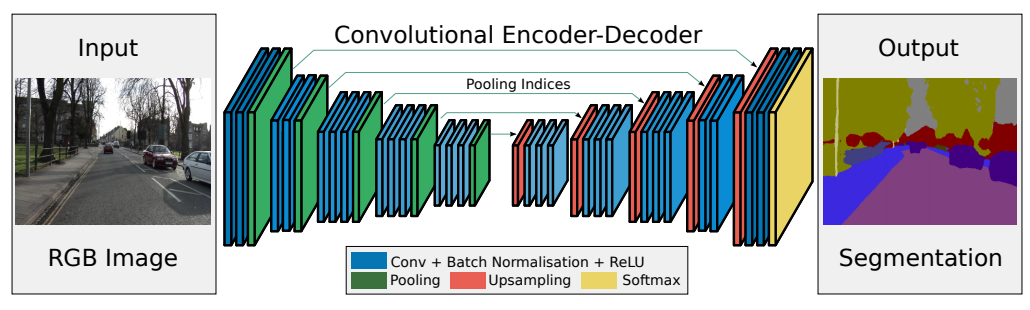

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

В самой статье можно подробнее посмотреть, из чего состоит модель и для чего существуют разные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,10)

In [ ]:
class ConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last_block=False):
        super().__init__()
        self.is_last_block = is_last_block

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if not self.is_last_block:
            x = self.relu(x)
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = ConvNormBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = ConvNormBlock(16, 32)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = ConvNormBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = ConvNormBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = ConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = ConvNormBlock(128, 64)

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = ConvNormBlock(64, 32)

        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = ConvNormBlock(32, 16)

        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = ConvNormBlock(16, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e, poll_ind0 = self.pool0(self.enc_conv0(x))
        e, poll_ind1 = self.pool1(self.enc_conv1(e))
        e, poll_ind2 = self.pool2(self.enc_conv2(e))
        e, poll_ind3 = self.pool3(self.enc_conv3(e))

        # bottleneck <1>
        b = self.bottleneck_conv(e)

        # decoder
        d = self.dec_conv0(self.upsample0(b, indices=poll_ind3))
        d = self.dec_conv1(self.upsample1(d, indices=poll_ind2))
        d = self.dec_conv2(self.upsample2(d, indices=poll_ind1))
        d = self.dec_conv3(self.upsample3(d, indices=poll_ind0))
        return torch.sigmoid(d)

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    #print(iou)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # please don't use nn.BCELoss. write it from scratch
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))

    # Усредняем потери по всем примерам
    loss = torch.mean(loss)

    return loss

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, show_plots=True):
    losses = []
    val_acc = []
    train_accuracy, val_accuracy = [], []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward

            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        losses.append(loss)

        # show intermediate results
        model.eval()  # testing mode
        score_train = score_model(model, iou_pytorch, data_tr, show_plots=False)
        score_val = score_model(model, iou_pytorch, data_val, show_plots=False)
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).cpu().detach()


        # Visualize tools
        if show_plots:
            clear_output(wait=True)
            plt.figure(figsize = (15, 7.5))
            for k in range(6):
                plt.subplot(3, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(3, 6, k+7)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Pred')
                plt.axis('off')

                plt.subplot(3, 6, k+13)
                plt.imshow(Y_val[k, 0], cmap='gray')
                plt.title('True')
                plt.axis('off')
            plt.suptitle('%d / %d - train score: %f, val score: %f' % (epoch+1, epochs, score_train, score_val))
            plt.show()
            train_accuracy.append(score_train)
            val_accuracy.append(score_val)
            plt.figure(figsize = (10, 5))
            plt.plot(train_accuracy, alpha=0.8, label="train_score")
            plt.plot(val_accuracy, alpha=0.8, label="val_score")
            plt.legend()
            plt.grid()
            plt.show()

        print('Val score:', score_val)
        val_acc.append(score_val)
        # print('val_acc', val_acc)
    return losses, val_acc

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data, treshold=0.5, show_plots=True):

    X_val, Y_val = next(iter(data))
    model.eval()  # testing mode
    with torch.no_grad():
        Y_hat = model(X_val.to(device)).cpu().detach()

    Y_hat = Y_hat > treshold

    if show_plots:
    # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Pred')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('True')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow(Y_val[k, 0].byte() & Y_hat[k, 0].byte(), cmap='gray')
            plt.title('Intersec')
            plt.axis('off')
        #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    model.eval()  # переводим модель в режим тестирования
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            # Отправляем данные на устройство (GPU, если доступно)
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            # Прямой проход (forward pass) для получения предсказаний
            Y_pred = model(X_batch) > treshold # treshold to binarize matrix

            # Вычисляем метрику на текущем батче и суммируем

            scores += metric(Y_label, Y_pred).mean().item()

    # Возвращаем усредненную метрику по всем батчам
    return scores / len(data)

## Основной момент: обучение

Сходимость определяется по изменению функции потерь на валидационной выборке.
С количеством эпох и параметрами оптимизатора можно играть.


In [ ]:
model = SegNet().to(device)

Число параметров модели

In [ ]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

736143

Обучение

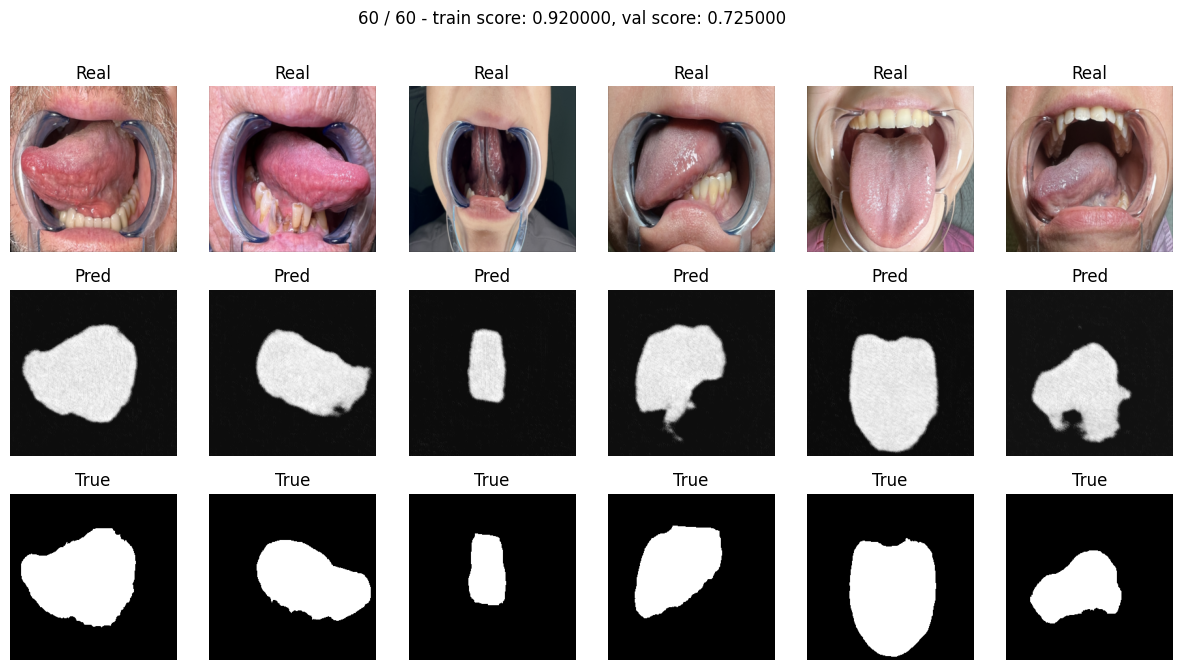

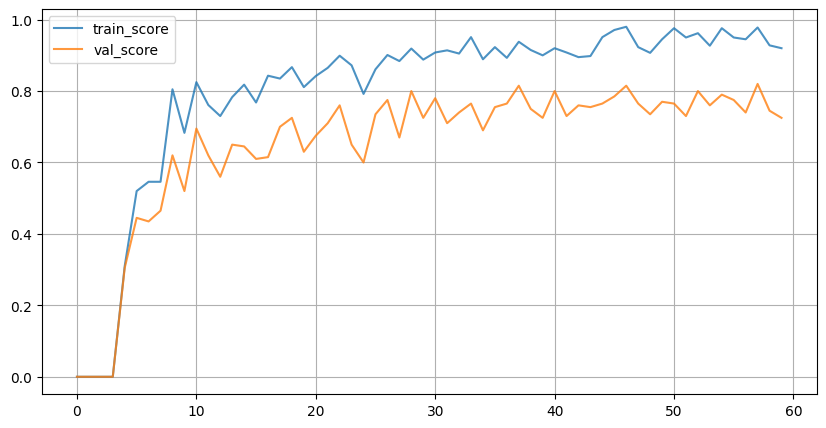

Val score: 0.7250000238418579


In [ ]:
max_epochs = 60
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)
None

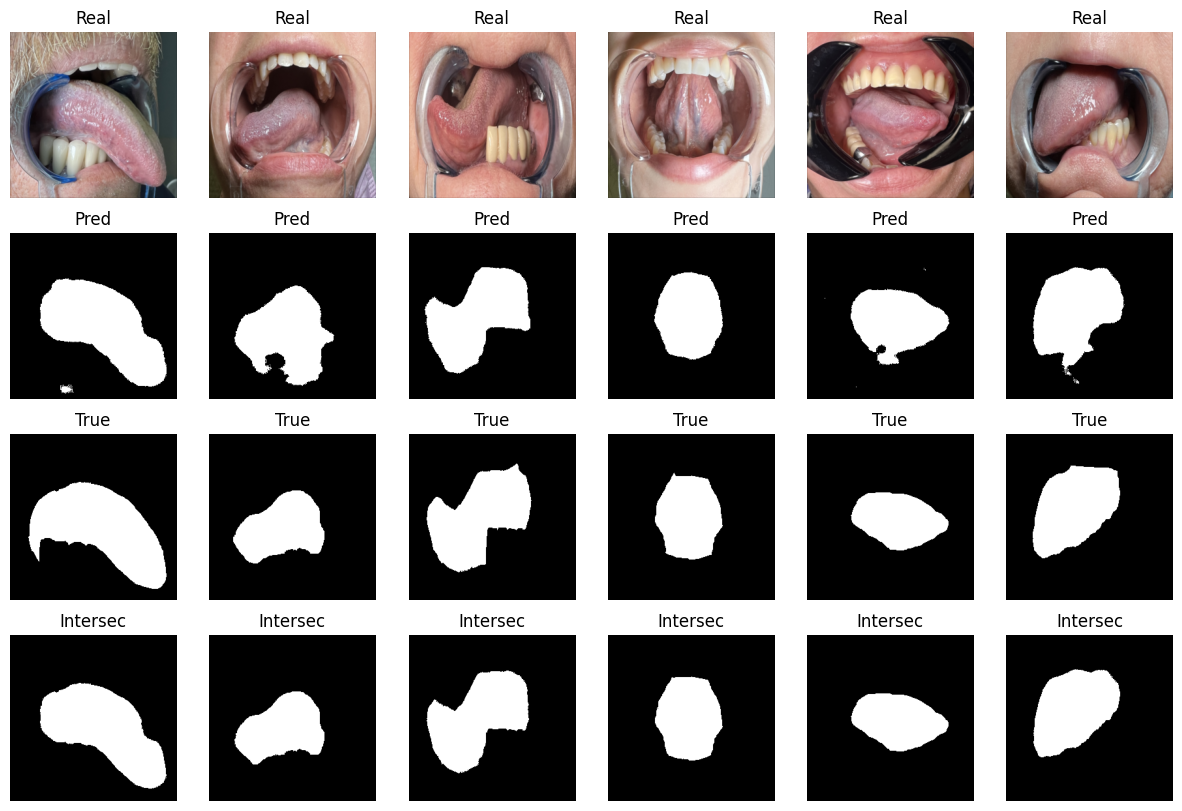

0.7250000238418579

In [ ]:
score_model(model, iou_pytorch, data_val)

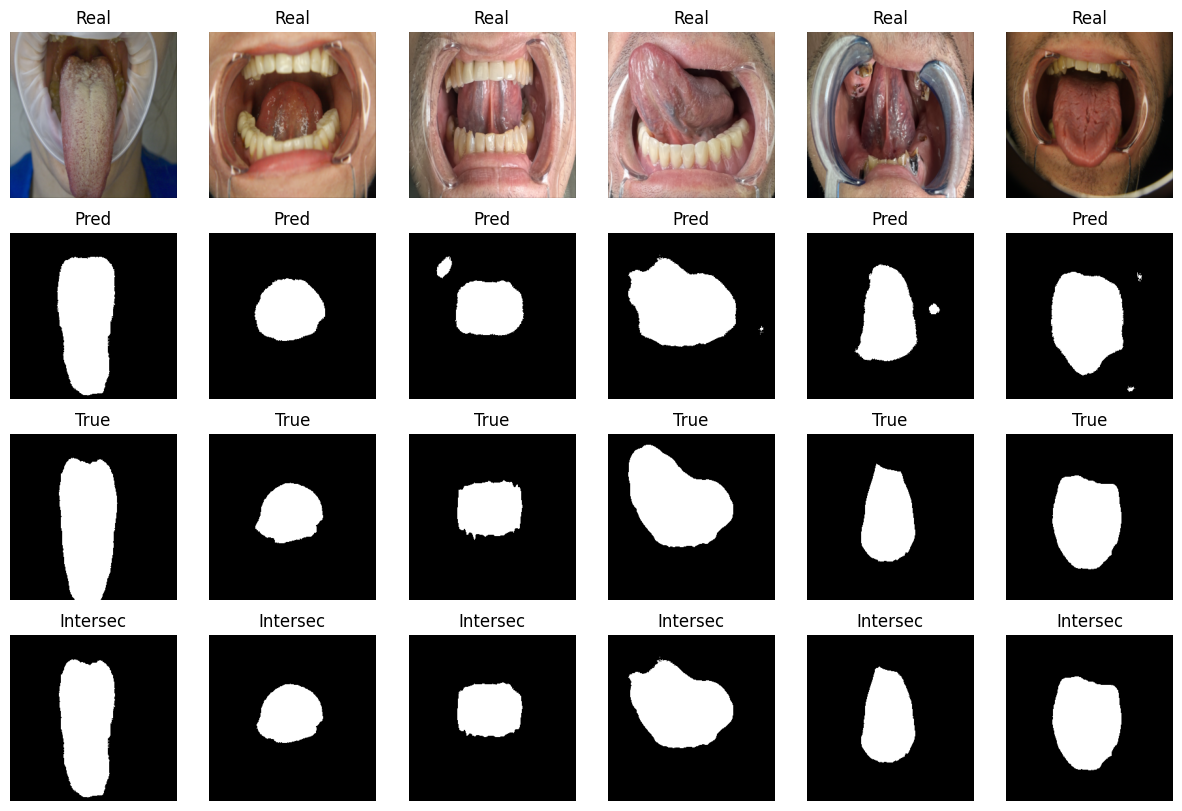

0.791666716337204

In [ ]:
score_model(model, iou_pytorch, data_ts)

Исходя из изображений выше, можно сказать, что модель в целом нормально работает на val и test выборках, метрика качества получается неплохой, хотя на тесте немного хуже, чем на train, где достигается почти идельный результат.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$




In [ ]:
def dice_loss(y_real, y_pred):
    eps =  1e-8
    num = 2 * (y_real * y_pred).sum()
    den = y_real.sum() + y_pred.sum()
    res = 1 - 1/(256*256) * ((num + eps) / (den + eps))
    return res

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

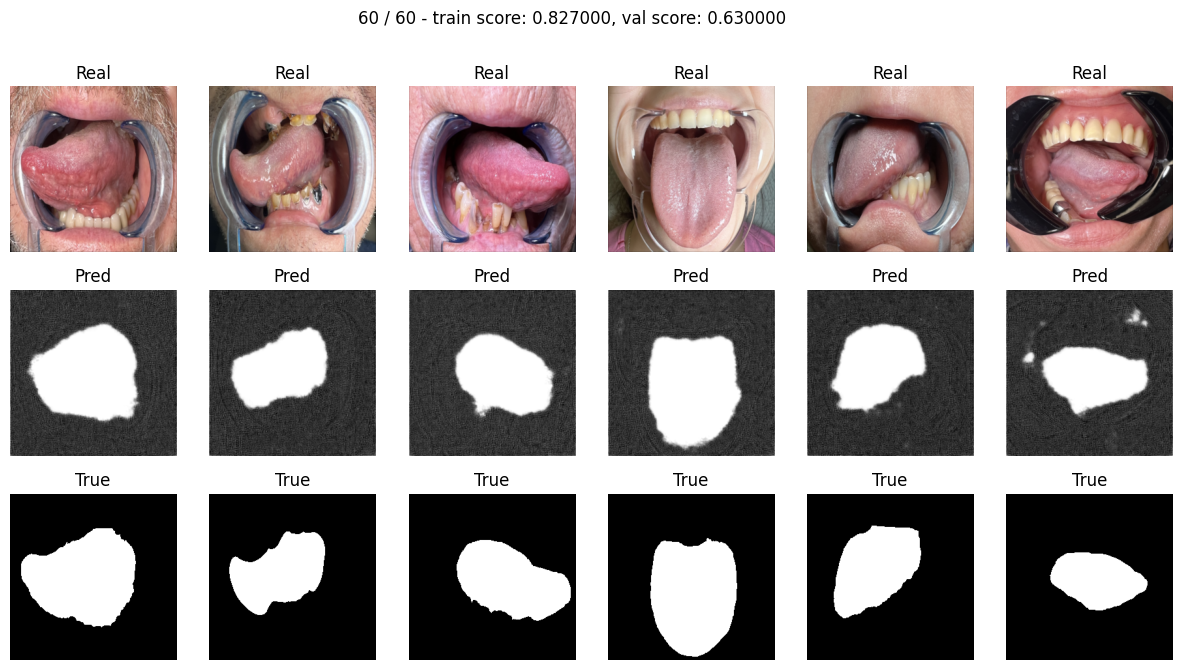

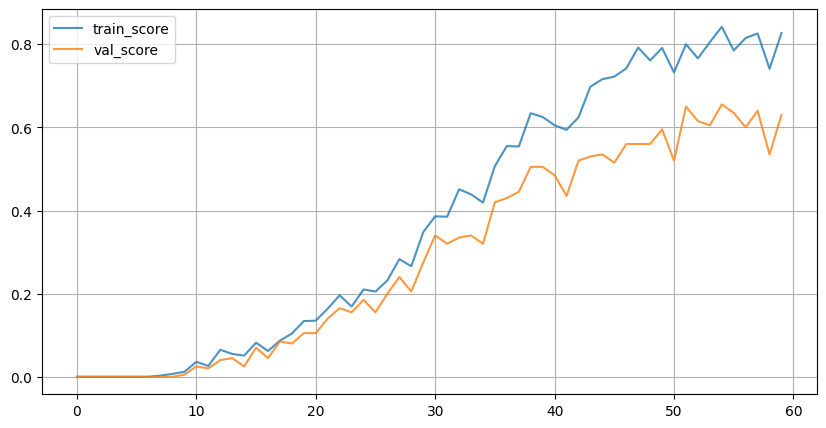

Val score: 0.6299999952316284


In [ ]:
max_epochs = 60
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=3e-4)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)
None

Видно, что к середине обучения качество уже вышло на плато, и дальше не обучалось, возможно, стоит взять меньше эпох и больше learning rate.

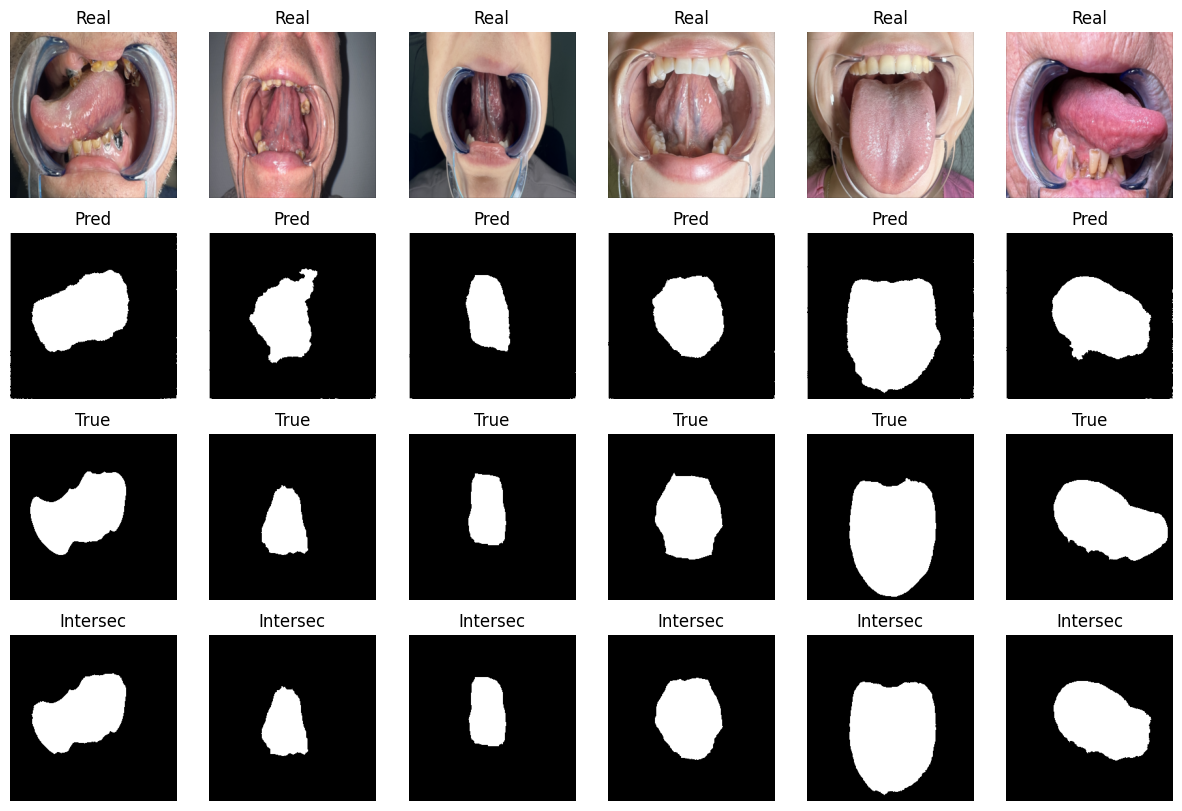

0.6100000441074371

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

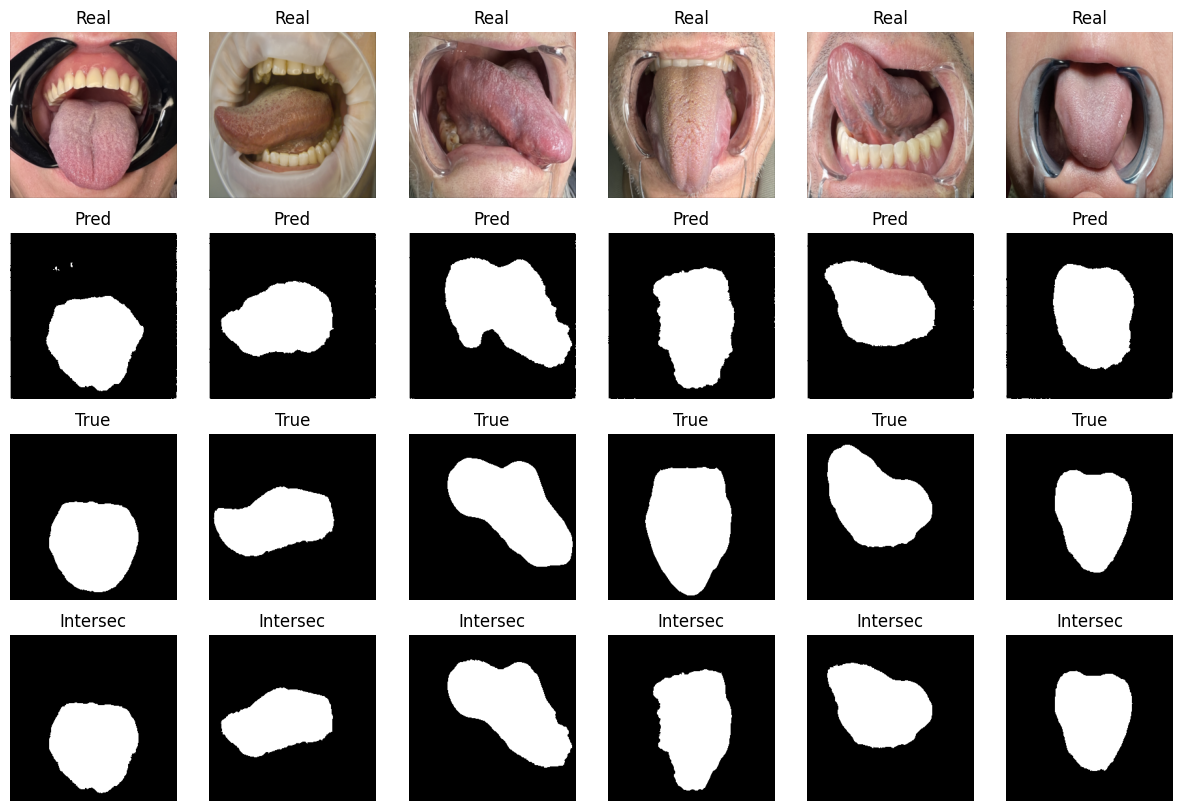

0.6600000262260437

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

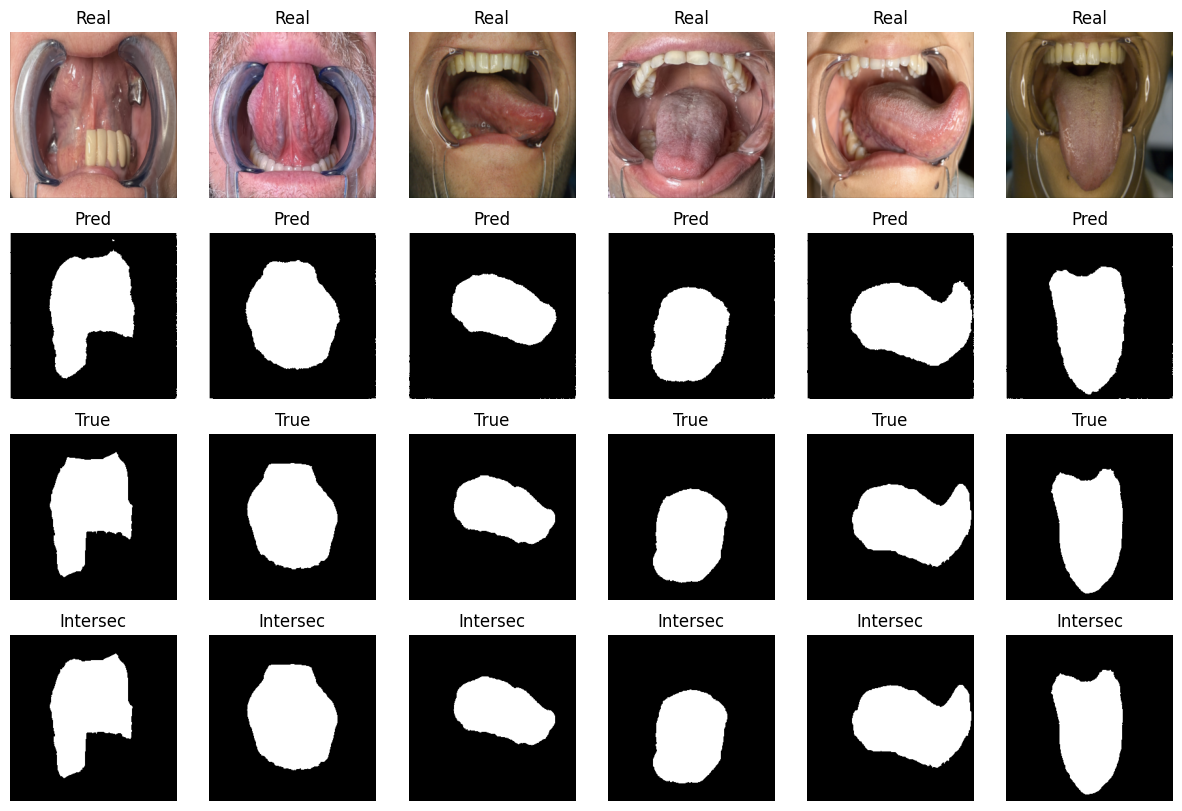

0.8270000278949737

In [ ]:
score_model(model_dice, iou_pytorch, data_tr)

С этой функцией потерь результаты получились тоже хорошими, хоть и хуже, чем с bce loss. Возможно, можно добиться ещё лучшего качества, если поумнее поперебирать количество эпох и оптимайзер. Но в то же время и с дефолтными параметрами получается неплохо.

Ещё однозначно можно было бы добиться лучшего результата, если обработать или выкинуть выбросы.

In [ ]:
from PIL import Image, ImageOps

In [ ]:
Image.open('drive/MyDrive/Colab Notebooks/Распознавание языка/Masks/266.bmp')

In [ ]:
im = Image.open('drive/MyDrive/Colab Notebooks/Распознавание языка/Masks/266.bmp')
im_invert = ImageOps.invert(im)
im_invert.save('drive/MyDrive/Colab Notebooks/Распознавание языка/Masks/266.bmp')

In [ ]:
Image.open('drive/MyDrive/Colab Notebooks/Распознавание языка/Masks/266.bmp')

Отлично, работает!

In [ ]:
im = Image.open('drive/MyDrive/Colab Notebooks/Распознавание языка/Masks/278.bmp')
im_invert = ImageOps.invert(im)
im_invert.save('drive/MyDrive/Colab Notebooks/Распознавание языка/Masks/278.bmp')

In [ ]:
im = Image.open('drive/MyDrive/Colab Notebooks/Распознавание языка/Masks/284.bmp')
im_invert = ImageOps.invert(im)
im_invert.save('drive/MyDrive/Colab Notebooks/Распознавание языка/Masks/284.bmp')

In [ ]:
images = []
masks = []
our_data = []
from skimage.io import imread
import os

for filename in sorted(os.listdir(image_path)):
    images.append(imread(os.path.join(image_path, filename)))

for filename in sorted(os.listdir(mask_path)):
    masks.append(imread(os.path.join(mask_path, filename)))

for filename in sorted(os.listdir(our_data_path)):
    our_data.append(imread(os.path.join(our_data_path, filename)))

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]
our_data_test = [resize(i, size, mode='constant', anti_aliasing=False) > 0.5 for i in our_data]
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
our_data_test = np.array(our_data_test, np.float32)
print(f'Loaded {len(X)} images')
print(len(masks))

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [200, 250])
print(len(tr), len(val), len(ts))

batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_ts_our = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
model_dice = SegNet().to(device)

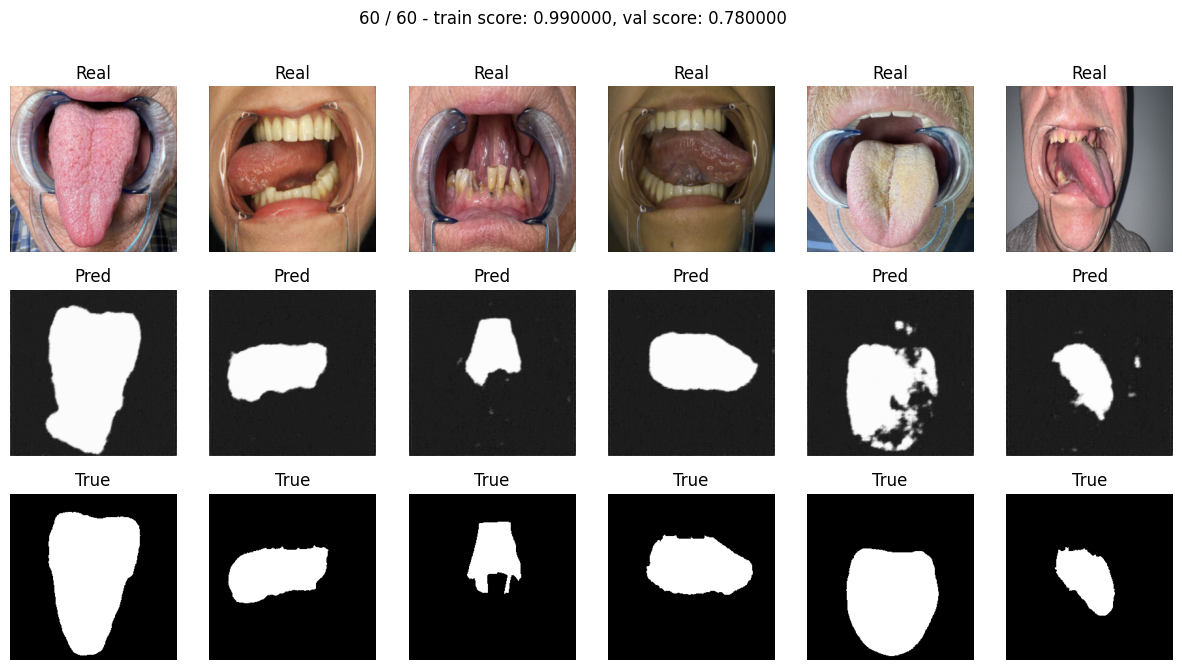

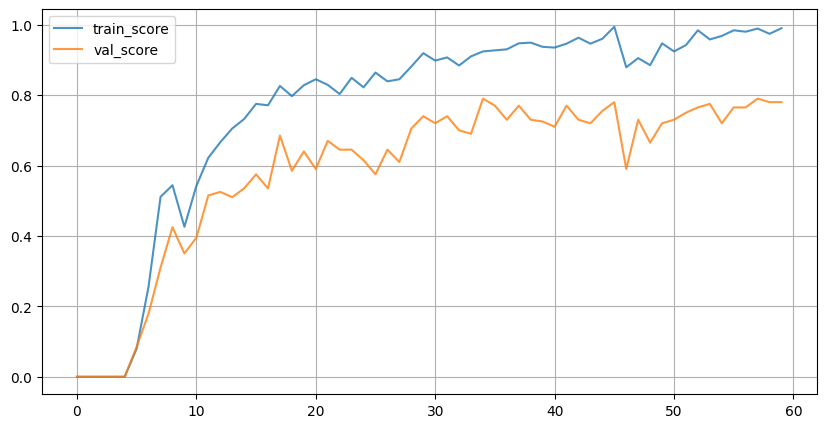

Val score: 0.7800000309944153


In [ ]:
max_epochs = 60
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-3)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)
None

При lr = 3e-4 почему-то первые 20 эпох модель очень плохо обучалась, скор был близок к нулю, поэтому я решила всё-таки увеличить lr. С новым шагом уже на 30 эпохе было достигнуто очень хорошее качество.

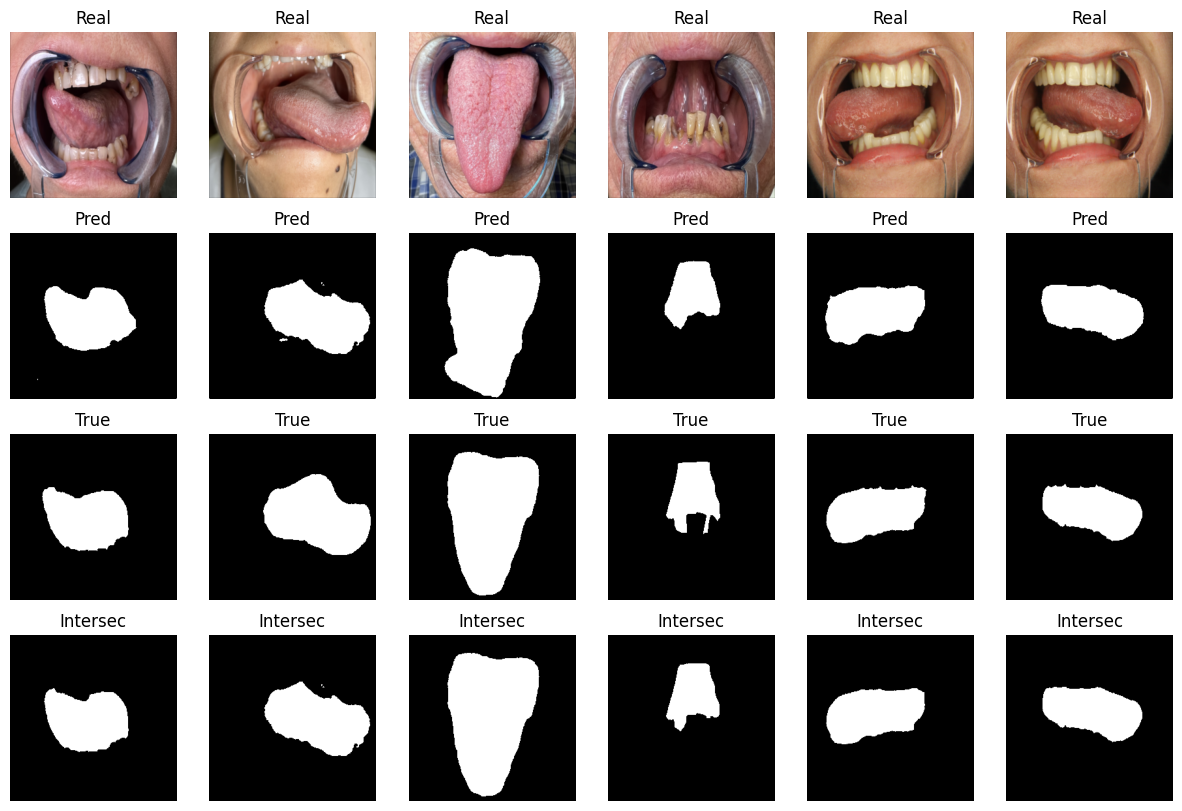

0.7800000309944153

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

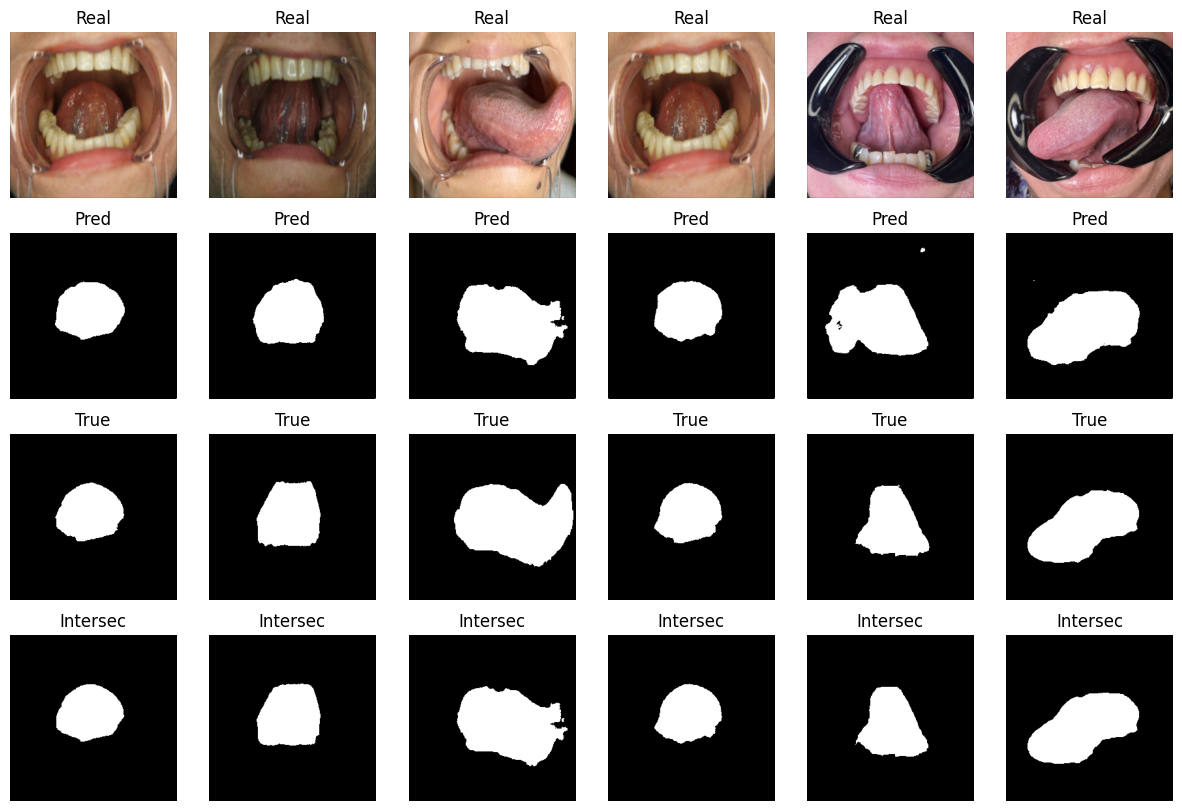

0.7716667056083679

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

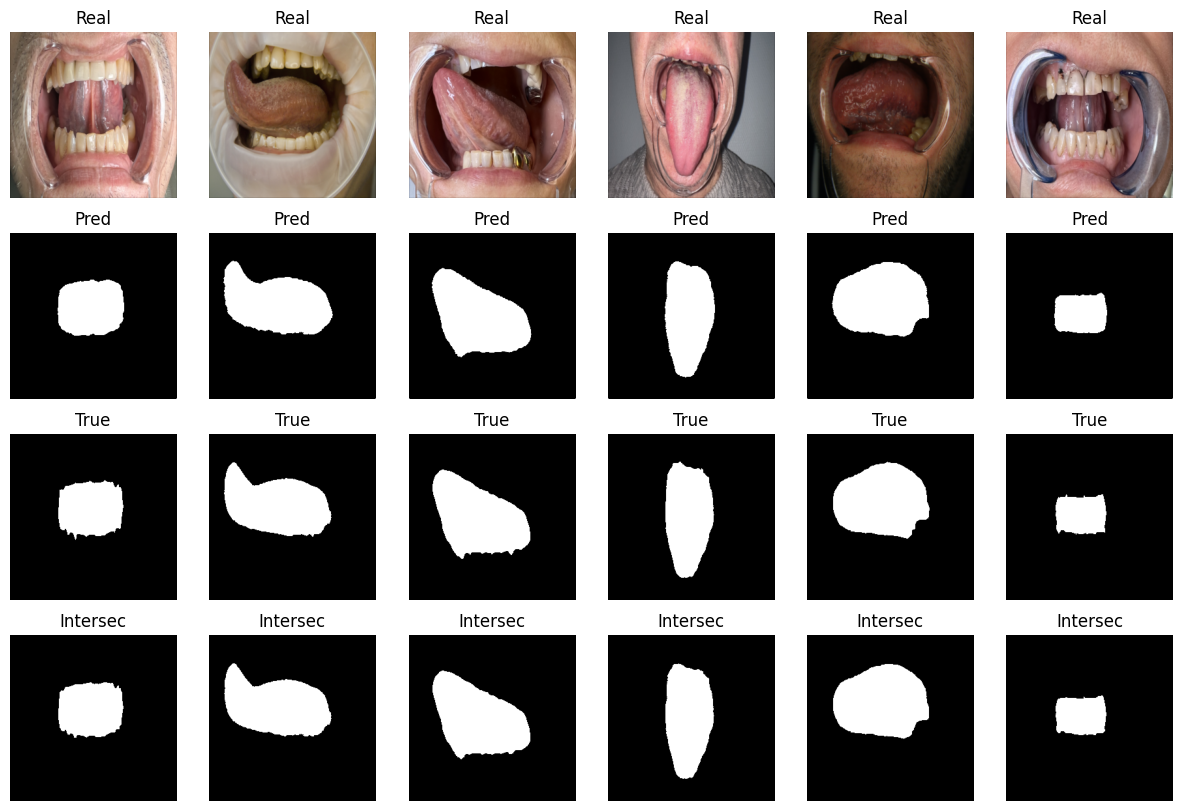

0.9899999737739563

In [ ]:
score_model(model_dice, iou_pytorch, data_tr)

Качество почти 97% на тестовой выборке , и в целом, гипотеза о том, что неправильные маски портили скор, подтвердилась, ведь на train достигается идеальный результат!